### PCA

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.decomposition import PCA, SparsePCA
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import seaborn as sns
import joblib
import os

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category

In [2]:
rng = 42

In [3]:
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [4]:
# set up folder to save results
#os.makedirs('export_run5_PCA')
prefix = 'export_run5_PCA/export'

In [5]:
def df_filtering(df, i_e = 'I', f_cols = []):

    filtered_df = df[df.i_e == i_e]
    filtered_df = filtered_df[f_cols+['act']]
    
    return filtered_df

def data_split(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1:]
    y = np.where(y['act']=='R',1,0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, stratify=y) 
    
    return X_train, X_test, y_train, y_test

In [6]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd',
                 'qty', 'unit', #'cartons',
                 'value', 'ship_date_mm']

export_df = df_filtering(df, i_e = 'E', f_cols = feature_cols)
X_train, X_test, y_train, y_test = data_split(export_df)

In [7]:
X_train.head()

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
65575,PINM,TRI,GREAT PEARL OYSTER,PINCTADA,MARGARITIFERA,MOL,PF,JP,T,W,A,BA,1.0,NO,0.0,5
126087,ALLM,SPE,AMERICAN ALLIGATOR,ALLIGATOR,MISSISSIPPIENSIS,REP,US,TT,M,W,A,MI,14.0,NO,2320.0,4
486033,PIMX,JWL,GOLD-LIP OYSTER,PINCTADA,MAXIMA,MOL,MX,HK,T,W,A,HA,1.0,NO,53.0,1
798703,MOLL,LIV,SHELLS MOLLUSCS,NaN_genus,NaN_species,MOL,VS,CA,T,W,A,LA,350.0,NO,208.0,12
392269,WDER,SKI,WHITE-TAILED DEER,ODOCOILEUS,VIRGINIANUS,MAM,US,CN,T,W,O,NW,744.0,NO,22190.0,2


#### Option 1: TargetEncoding on Categorical and RobustScaler on Numeric Cols

In [8]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']

ct_target = make_column_transformer(
    (RobustScaler(), numerical_var),
    (TargetEncoder(), categorical_var),
    remainder='passthrough')

In [9]:
X_train_t = ct_target.fit_transform(X_train, y_train)
X_test_t = ct_target.transform(X_test)

In [10]:
X_train_t[:2]

array([[-1.06467927e-01, -9.18367347e-02,  1.17187500e-03,
         1.41166405e-02,  1.17187500e-03,  3.24858757e-03,
         1.04239055e-03,  4.55603725e-03,  0.00000000e+00,
         6.34431783e-03,  8.38549976e-03,  7.48914176e-03,
         5.48979767e-03,  3.54484225e-04,  8.36848617e-03,
         5.00000000e+00],
       [ 5.11046047e-01,  4.08163265e-02,  5.99026582e-03,
         3.08513794e-03,  5.99026582e-03,  5.99026582e-03,
         5.99026582e-03,  9.32896890e-03,  7.68923905e-03,
         9.43396226e-03,  3.24745616e-03,  7.48914176e-03,
         5.48979767e-03,  5.40807723e-03,  8.36848617e-03,
         4.00000000e+00]])

#### Option 2: TargetEncoding on Categorical and RobustScaler on all

In [11]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    #(RobustScaler(), feature_cols),    #operation is parallelized and concatenated together
    remainder='passthrough')

pipe = Pipeline([('targetEncoding', ct_target), 
                 ('robustscaler', RobustScaler())
                ], verbose=False)

In [12]:
X_train_t = pipe.fit_transform(X_train, y_train)
X_test_t = pipe.transform(X_test)

In [14]:
X_train_t[:]

numpy.ndarray

In [15]:
X_train_t.shape

(224505, 16)

#### PCA

In [27]:
test_df = pd.DataFrame(X_train_t, columns=feature_cols)
test_df.head()

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
0,-0.343234,1.396473,-0.362209,-0.327859,-0.415738,-0.58464,-2.251123,-0.633043,0.000000,0.0,0.000000,-0.744670,0.0,-0.091837,-0.106468,-0.2
1,0.360091,-0.540181,0.379998,0.216478,0.187148,0.00000,0.000000,0.789445,-0.005138,0.0,0.000000,-0.118453,0.0,0.040816,0.511046,-0.4
2,0.000000,0.159178,0.000000,-0.327859,-0.108344,-0.58464,-1.310915,5.098605,0.000000,0.0,0.000000,-0.453516,0.0,-0.091837,-0.092361,-1.0
3,0.753518,0.000000,0.796337,0.274107,0.689910,-0.58464,-1.425082,0.000000,0.000000,0.0,0.000000,0.600411,0.0,3.469388,-0.051105,1.2
4,1.950041,0.512210,2.057842,2.619931,1.506355,0.41536,0.000000,6.782299,0.000000,0.0,0.005824,0.132337,0.0,7.489796,5.799840,-0.8


In [28]:
from sklearn.decomposition import TruncatedSVD
test = TruncatedSVD(n_components=5, random_state=rng)
X_train_svd = test.fit_transform(test_df)
print(X_train_t.shape, X_train_svd.shape)

(224505, 16) (224505, 5)


In [42]:
test.get_feature_names_out(input_features=feature_cols)

array(['truncatedsvd0', 'truncatedsvd1', 'truncatedsvd2', 'truncatedsvd3',
       'truncatedsvd4'], dtype=object)

In [43]:
[feature_cols[i] for i in test.components_[0].argsort()[::-1]]

['unit',
 'value',
 'ctry_ie',
 'species',
 'pt_cd',
 'specific_generic_name',
 'species_code',
 'wildlf_desc',
 'genus',
 'ship_date_mm',
 'trans_mode',
 'qty',
 'purp',
 'wildlf_cat',
 'src',
 'ctry_org']

In [40]:
test.__dict__

{'algorithm': 'randomized',
 'n_components': 5,
 'n_iter': 5,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': 42,
 'tol': 0.0,
 'feature_names_in_': array(['species_code', 'wildlf_desc', 'specific_generic_name', 'genus',
        'species', 'wildlf_cat', 'ctry_org', 'ctry_ie', 'purp', 'src',
        'trans_mode', 'pt_cd', 'qty', 'unit', 'value', 'ship_date_mm'],
       dtype=object),
 'n_features_in_': 16,
 'components_': array([[ 1.62910430e-06,  1.14995675e-06,  1.68587769e-06,
          2.91694036e-07,  3.36896558e-06, -2.32112950e-06,
         -5.26343212e-06,  9.90281036e-06, -1.12469659e-10,
         -5.21236139e-06,  3.83744062e-09,  2.55411394e-06,
          9.77991994e-10,  9.99999993e-01,  1.14798049e-04,
          1.31216614e-07],
        [ 3.65987524e-03,  3.20947828e-03,  3.85391568e-03,
          4.26320594e-03,  2.19092622e-03, -1.10385727e-05,
          1.85459640e-02,  1.29669229e-03, -8.40080163e-07,
          8.15029482e-03,  2.46516046e-

In [35]:
test.explained_variance_ratio_

array([9.99665748e-01, 2.74203513e-04, 3.87102636e-05, 1.04403346e-05,
       5.53721901e-06])

In [30]:
test.get_feature_names_out()

array(['truncatedsvd0', 'truncatedsvd1', 'truncatedsvd2', 'truncatedsvd3',
       'truncatedsvd4'], dtype=object)

In [80]:
pca = PCA(n_components=5, random_state=rng)
X_train_pca = pca.fit_transform(X_train_t)
print(X_train_t.shape, X_train_pca.shape)

(224505, 16) (224505, 5)


In [21]:
def plot_pca(pca, f_names, top_k = 10):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=f_names
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 5, 1), ['First PC', 'Second PC','Third PC', 'Fourth PC', 'Fifth PC'], fontsize = 16)
    plt.colorbar()

<AxesSubplot:>

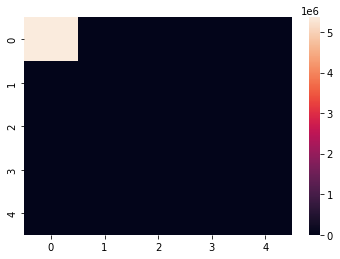

In [82]:
sns.heatmap(empirical_covariance(X_train_pca))

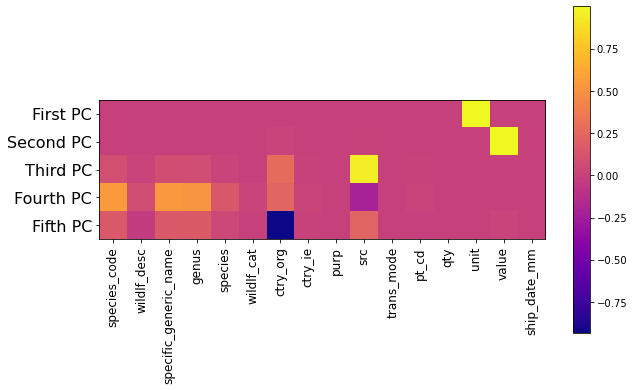

In [83]:
plot_pca(pca, feature_cols)

In [84]:
print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)  

explained_variance_ratio: [9.99665749e-01 2.74209180e-04 3.87099401e-05 1.04386592e-05
 5.53617466e-06]
sum of explained variance ratios: 0.9999946425792864
singular values: [1096869.25682961   18166.38244647    6825.56658821    3544.45785853
    2581.26355646]


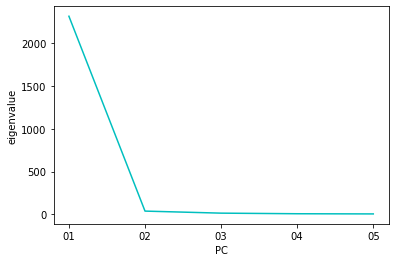

In [64]:
df = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_),
                   'PC':['01','02','03','04','05']}) #                   'PC':['01','02','03','04','05']}) #
sns.lineplot(x = 'PC',y = "eigenvalue", data = df, color="c");

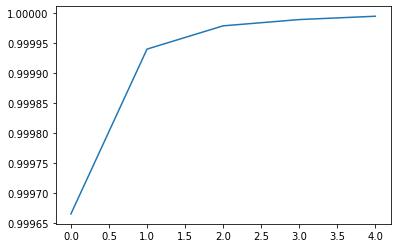

In [67]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

0    0.999666
1    0.999940
2    0.999979
3    0.999989
4    0.999995
Name: explained var ratio, dtype: float64

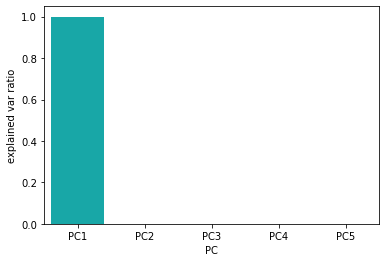

In [65]:
df = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_,
                   'PC':['PC1','PC2','PC3','PC4','PC5']})  #,'PC6','PC7','PC8','PC9','PC10'
sns.barplot(x = 'PC',y = "explained var ratio", data = df, color="c");
np.cumsum(df['explained var ratio'])

#### Archive - do not run 

In [ ]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    (StandardScaler(), numerical_var),
    remainder='passthrough')